In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
from astroquery.esa.euclid.core import EuclidClass, Euclid
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from multiprocessing.pool import ThreadPool
from astropy import wcs
from astropy.io import fits
import numpy as np
import pandas as pd
#import sep
import glob
import os

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.table import Table
from astropy.visualization import astropy_mpl_style, ImageNormalize, ZScaleInterval, PercentileInterval, AsinhStretch, SqrtStretch, SquaredStretch
plt.style.use(astropy_mpl_style)
pd.set_option('display.max_colwidth', 0) #to show full column content (no wrapping and no dots)

In [90]:
# help(Euclid)

In [57]:
import morphology_utils
import cutout_utils
import pipeline_utils


In [92]:
help(Euclid.login)

Help on method login in module astroquery.esa.euclid.core:

login(*, user=None, password=None, credentials_file=None, verbose=False) method of astroquery.esa.euclid.core.EuclidClass instance
    Description
    -----------
    Performs a login
    
    User and password can be used or a file that contains user name and password
    (2 lines: one for user name and the following one for the password)
    
    Parameters
    ----------
    user : str, mandatory if 'file' is not provided, default None
        login name
    password : str, mandatory if 'file' is not provided, default None
        user password
    credentials_file : str, mandatory if no 'user' & 'password' are provided
        file containing user and password in two lines
    verbose : bool, optional, default 'False'
        flag to display information about the process



In [93]:
# change to your username
# Euclid.login(user='mwalms01')
Euclid.login(credentials_file='/media/home/my_workspace/_credentials/euclid_login.txt')

INFO: Login to Euclid TAP server [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid data service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid cutout service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]


In [59]:
tile_index = 102010567

In [60]:
query_str = f"""
SELECT * FROM sedm.mosaic_product 
WHERE (tile_index='{tile_index}')
AND (filter_name='VIS')
"""
print(query_str)
job = Euclid.launch_job(query_str)
tile = job.results.to_pandas().squeeze()
# add ra/dec limits (approx)
tile = pipeline_utils.get_tile_extents(tile, pipeline_utils.WIDE)


SELECT * FROM sedm.mosaic_product 
WHERE (tile_index='102010567')
AND (filter_name='VIS')



In [61]:
# # # galaxies in a tile
# # df = pd.read_csv('/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/pipeline/catalogs/102010567_mer_catalog.csv')


# current_cuts = pipeline_utils.find_zoobot_sources_in_tile(tile, segmentation_area=1200)  # or more
# current_cuts.head() 

In [62]:
query_str = f"""
            SELECT right_ascension, declination, segmentation_area, kron_radius, ellipticity, flux_segmentation, object_id, spurious_prob, vis_det, det_quality_flag, gaia_id, flag_vis, flag_y, she_flag, point_like_flag, point_like_prob, mumax_minus_mag
            FROM catalogue.mer_catalogue
            WHERE segmentation_area > 1200
            AND gaia_id IS NULL

            AND right_ascension > {tile['ra_min']} AND right_ascension < {tile['ra_max']}
            AND declination > {tile['dec_min']} AND declination < {tile['dec_max']}
            
            """
            # AND more criteria?
            # suggestions:
        
                                # AND vis_det=1
                    # AND spurious_prob < 0.2
            # 
#                                     
            # AND spurious_prob < 0.2
            # the MER flags?
# 'http error detected' means log in again, above
Euclid.launch_job_async(query_str, background=False, dump_to_file=True, output_file='latest_mer_catalogue.csv', output_format='csv')
df = pd.read_csv('latest_mer_catalogue.csv', dtype={'object_id': str})
df['tile_index'] = tile_index
df['mag_segmentation'] = -2.5 * np.log10(df['flux_segmentation']) + 23.9  # total vis mag in segmention mask
len(df)



665

In [63]:

#  # which fraction of galaxies at IE < 20, 20.5, 21, 21.5, 22 are selected by the area > 1200px criterion ? and how much would it increase if we used 1000 or 800px instead 

# df = df.sort_values('segmentation_area')
# fig, ax = plt.subplots()
# for criteria_n, area_criteria in enumerate([800, 1000, 1200]):
#     # fraction of remaining galaxies vs magnitude
    
#     # of all galaxies passing the area criteria
# #     .query(f'segmentation_area > {area_criteria}')
#     df_matching = df.sort_values('mag_segmentation').reset_index(drop=True)
#     ax.plot(df_matching['mag_segmentation'], (df_matching['segmentation_area'] > area_criteria).cumsum(), label=f'{area_criteria}px cut')
#     ax.set_xlim([17, 24])
# ax.legend()
# ax.set_xlabel('VIS segmentation mag')
# ax.set_ylabel('Galaxies at least as bright as (mag) (per MER tile)')

In [64]:

#  # which fraction of galaxies at IE < 20, 20.5, 21, 21.5, 22 are selected by the area > 1200px criterion ? and how much would it increase if we used 1000 or 800px instead 

# df = df.sort_values('segmentation_area')
# fig, ax = plt.subplots()
# for criteria_n, area_criteria in enumerate([400, 800, 1000, 1200]):
#     # fraction of remaining galaxies vs magnitude
    
#     bins = np.linspace(17, 24, 20)
    
#     # of all galaxies passing the area criteria
# #     
#     df_matching = df.query(f'segmentation_area > {area_criteria}')
#     ax.hist(df_matching['mag_segmentation'], label=f'{area_criteria}px cut', histtype='step', bins=bins)
#     ax.set_xlim([17, 24])
# ax.legend()
# ax.set_xlabel('VIS segmentation mag')
# ax.set_ylabel('Galaxies passing area cut (per MER tile)')

In [65]:
# df['she_flag'].isna().mean()  # useless right now

In [66]:
# plt.hist(df['point_like_prob'], bins=50)

In [67]:
# df['point_like_flag'].isna().mean()  # strangely, much rarer than point like p, somewhat explained in the docs, best not to use

In [68]:
# df['mumax_minus_mag']

## Your turn

In [69]:
df_subset = df.copy()
# TODO apply your own selection cuts on galaxies_in_tile
# TODO add new columns using the query above, if helpful


# for example
# df_subset = df_subset.query('mag_segmentation < 24')
# print((df_subset['spurious_prob'] > 0.2).mean())
# df_subset = df_subset.query('spurious_prob > 0.2')  # what do the spurious detections look like?

df_subset = df_subset.query('segmentation_area > 1200')
# df_subset = df_subset.query('flag_vis == 2')
# df_subset = df_subset.query('flag_vis == 2')

# .query('mag_segmentation > 20.5')

#query('mag_segmentation < 21.5')



In [70]:
# leave this part alone

cutout_folder = '/media/home/team_workspaces/Galaxy-Zoo-Euclid/temp_latest_selection'
df_subset = df_subset.reset_index(drop=True)
df_subset['cutout_loc'] = df_subset.apply(lambda x: pipeline_utils.get_cutout_loc(cutout_folder, x, output_format='jpg'), axis=1)

In [71]:
len(df_subset)

665

## Visualise the selected galaxies

In [72]:
# corresponding tiles

# I already saved that tile here
vis_loc = '/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/pipeline/v1_challenge_launch/tiles/EUC_MER_BGSUB-MOSAIC-VIS_TILE102010567-EE51A8_20240306T053728.760996Z_00.00.fits'
nisp_loc = '/media/home/team_workspaces/Galaxy-Zoo-Euclid/data/pipeline/v1_challenge_launch/tiles/EUC_MER_BGSUB-MOSAIC-NIR-Y_TILE102010567-EBC499_20240306T040953.226005Z_00.00.fits'

df_subset['jpg_loc_composite'] = df_subset.apply(
    lambda x: pipeline_utils.get_cutout_loc(cutout_folder, x, output_format='jpg', version_suffix='composite', oneway_hash=False), axis=1)
df_subset['jpg_loc_vis_only'] = df_subset.apply(
    lambda x: pipeline_utils.get_cutout_loc(cutout_folder, x, output_format='jpg', version_suffix='vis_only', oneway_hash=False), axis=1)
df_subset['jpg_loc_vis_lsb'] = df_subset.apply(
    lambda x: pipeline_utils.get_cutout_loc(cutout_folder, x, output_format='jpg', version_suffix='vis_lsb', oneway_hash=False), axis=1)
                     


df_to_visualise = df_subset.sample(min(len(df_subset), 32), random_state=42).sort_values('object_id').reset_index(drop=True)
# df_to_visualise = df_subset.sort_values('segmentation_area', ascending=False).reset_index(drop=True)[:32]
pipeline_utils.save_cutouts(vis_loc, nisp_loc, df_to_visualise.copy(), overwrite=False)

loading tile
tile loaded
galaxy 0 of 32


In [73]:
# df_to_visualise['cutout_loc'].apply(os.path.isfile)

In [74]:
# not_stars = df_subset[df_subset['gaia_id'].isna()]
                    
# stars = df_subset[~df_subset['gaia_id'].isna()]

# plt.scatter(not_stars['mag_segmentation'], not_stars['segmentation_area'], label='mostly not stars')
# plt.scatter(stars['mag_segmentation'], stars['segmentation_area'], label='definitely stars')
# plt.yscale('log')
# plt.legend()

# x = np.linspace(12, 22)

# def max_area_given_mag(mag):
#     return 10 ** (10.7-0.4*mag)

# y = max_area_given_mag(x)
# plt.plot(x, y)

# df_subset['expected_max_area'] = max_area_given_mag(df_subset['mag_segmentation'])
# df_subset['area_star_flag'] = df_subset['expected_max_area'] > df_subset['segmentation_area']

# # df_subset = df_subset.query('area_star_flag')
# # len(df_subset)

In [75]:
# df_subset[['segmentation_area', 'expected_max_area']]

In [76]:
# df_subset['area_star_flag'].mean()

In [77]:
# bins = np.linspace(0, 1, 50)
# _ = plt.hist(stars['point_like_prob'], alpha=.5, density=True, bins=bins, label='stars')
# _ = plt.hist(not_stars['point_like_prob'], alpha=.5, density=True, bins=bins, label='mostly not stars')
# plt.legend()

In [78]:
# bins = np.linspace(0, 1, 50)
# _ = plt.hist(stars['mumax_minus_mag'], alpha=.5, density=True, bins=bins, label='stars')
# _ = plt.hist(not_stars['mumax_minus_mag'], alpha=.5, density=True, bins=bins, label='mostly not stars')
# plt.legend()

In [79]:
# not_stars['point_like_prob'].max()

In [80]:
# df_subset

In [81]:
pd.crosstab(df['spurious_prob'] > 0.2, df['vis_det'] == 1)

vis_det,False,True
spurious_prob,,
False,5,524
True,129,7


Text(0, 0.5, 'Galaxies in tile')

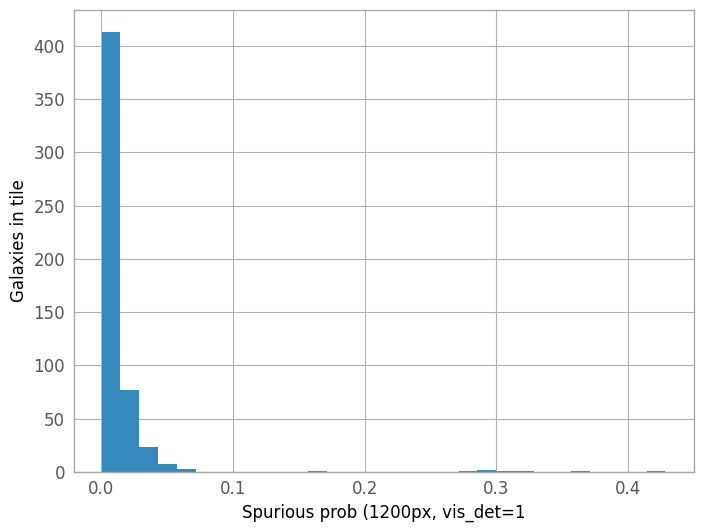

In [88]:
# df['spurious_prob'].hist(bins=30)
df.query('vis_det == 1')['spurious_prob'].hist(bins=30)
plt.xlabel('Spurious prob (1200px, vis_det=1')
plt.ylabel('Galaxies in tile')

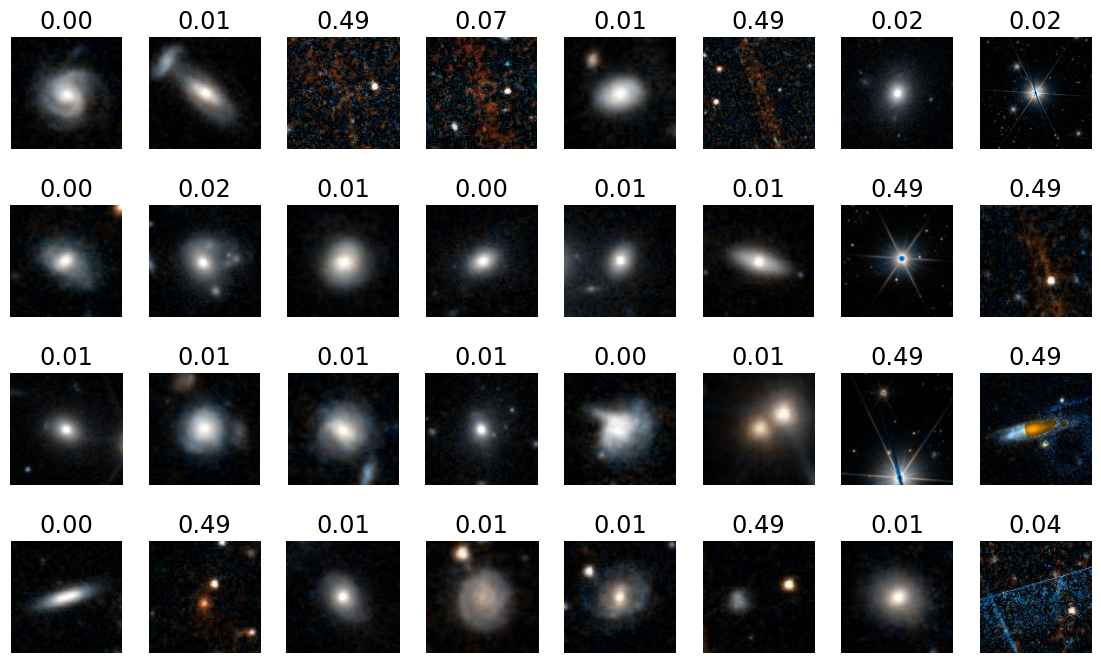

In [82]:
fig, axes = plt.subplots(ncols=8, nrows=4, figsize=(14, 8))
axes = axes.flatten()
for ax_n, ax in enumerate(axes):
    try:
        im = Image.open(df_to_visualise['jpg_loc_composite'][ax_n])
        # ax.set_title(df_to_visualise['segmentation_area'][ax_n])
        ax.set_title('{:.2f}'.format(df_to_visualise['spurious_prob'][ax_n]))
        ax.imshow(im)
    except KeyError:
        pass  # out of galaxies
    ax.axis('off')

In [83]:
# df_to_visualise.iloc[21]

In [84]:
# https://www.legacysurvey.org/viewer?ra=82.3065&dec=-60.8631&layer=ls-dr9&zoom=15